# 네이버 영화리뷰 감정분석 문제에 SentencePiece 적용해 보기

아마 여러분들은 [네이버 영화리뷰 감정분석 태스크](https://github.com/e9t/nsmc/)를 한 번쯤은 다루어 보았을 것입니다. 한국어로 된 corpus를 다루어야 하므로 주로 KoNLPy에서 제공하는 형태소 분석기를 사용하여 텍스트를 전처리해서 RNN 모델을 분류기로 사용했을 것입니다.

만약 이 문제에서 tokenizer를 sentencepiece로 바꾸어 다시 풀어본다면 더 성능이 좋아질까요? 비교해 보는 것도 흥미로울 것입니다.

- 네이버 영화리뷰 감정분석 코퍼스에 sentencepiece를 적용시킨 모델 학습하기

- 학습된 모델로 sp_tokenize() 메소드 구현하기

- 구현된 토크나이저를 적용하여 네이버 영화리뷰 감정분석 모델을 재학습하기

- KoNLPy 형태소 분석기를 사용한 모델과 성능 비교하기

- (보너스) SentencePiece 모델의 model_type, vocab_size 등을 변경해 가면서 성능 개선 여부 확인하기

- Word Vector는 활용할 필요가 없습니다. 활용이 가능하지도 않을 것입니다.

- 머지않아 SentencePiece와 BERT 등의 pretrained 모델을 함께 활용하는 태스크를 다루게 될 것입니다.

# . 0. 데이터 다운로드 및 분석
```
$ wget https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt
$ wget https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt
$ mv ratings_*.txt ~/aiffel/sentiment_classification
```

In [1]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter

In [2]:
# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/ratings_test.txt')



In [3]:
train_data.head(3)

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0


In [4]:
train_data.drop_duplicates(subset=['document'], inplace=True)
train_data = train_data.dropna(how = 'any')

## 데이터프레임에서 document 칼럼 데이터 리스트로 저장

In [5]:
raw_train = train_data['document'].tolist()
raw_test = train_data['document'].tolist()

raw_train = list(map(str, raw_train)) # 다시 문자열로 변환
raw_test = list(map(str, raw_test)) # 다시 문자열로 변환

## 데이터 길이 및 문장출력

In [6]:
print("train Data Size:", len(raw_train))
print("test Data Size:", len(raw_test))

print("Example:")
for sen in raw_train[0:100][::20]: print(">>", sen)

train Data Size: 146182
test Data Size: 146182
Example:
>> 아 더빙.. 진짜 짜증나네요 목소리
>> 나름 심오한 뜻도 있는 듯. 그냥 학생이 선생과 놀아나는 영화는 절대 아님
>> 단순하면서 은은한 매력의 영화
>> 보는내내 그대로 들어맞는 예측 카리스마 없는 악역
>> 뭐냐..시작하고 3분만에 나왔다. 리플릿 사진 보며 불안하더니만..


## 문장 길이 정보 시각화

x축은 문장길이     
y축은 빈도 수

Data Size: 146182
문장의 최단 길이: 1
문장의 최장 길이: 146
문장의 평균 길이: 35


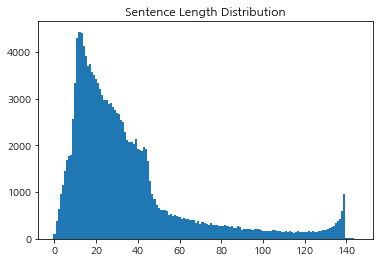

In [7]:
min_len = 999
max_len = 0
sum_len = 0
print("Data Size:", len(raw_train))
for sen in raw_train:
    length = len(str(sen))
    #print(sen)
    #print(type(length))
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(raw_train))

sentence_length = np.zeros((max_len), dtype=np.int)

for sen in raw_train:
    sentence_length[len(str(sen))-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

## 길이가 n인 문장 파악하는 함수
def check_sentence_with_length(raw, length)

In [8]:
def check_sentence_with_length(raw, length):
    count = 0
    for sen in raw:
        if len(str(sen)) == length:
            print(sen)
            count += 1
            if count > 30: return 
            # [질문1]이건 왜 사용한건가?
            # 아마 50개 미만까지 출력하기위해서인것 같다.

### 문장길이가 1인 경우(최대 50개까지 출력)

In [9]:
check_sentence_with_length(raw_train, 1)

아
잼
1
4
굿
짱
휴
.
음
?
ㅎ
ㅋ
즐
♥
굳
네
ㅇ
k
ㅠ
쒯
♬
토
O
똥
z
헐
삼
꽝
!
풉
ㅅ


### 문장길이가 146경우(최대 50개까지 출력)

In [10]:
check_sentence_with_length(raw_train, 146)

"스폰으로 먹고사는 방송이라 어쩔수 없다고 하지만. 이건 그냥 비현실적인 자동차만;...독일3사&슈퍼카 홍보 프로그램도 아니구.대중적인 자동차 방송으로 이루어 졌으면 합니다. 보는내내 ""카탈로그 책자""를 ""동영상으로 보여주는 방송"" 같아서 씁쓸하네요.!"
"""니 짓은 생각않고, 웬 복수!""의 교훈이라! 그럼 ""서바이벌 액션""으로 홍보하면 안되지! 초반 45분은 멋지게 열더니.. 억지 반전, 하드고어로 시간끌다가, 허둥지둥 화해로 끝내버리네. 90분 러닝타임에 엔딩자막만 11분 틀어주는 해괴망측한 영화~!"
"2007.02.25_ 벌교의 한 국밥집_ 점심: ""갸는 첫째고, 저 놈은 우리 둘째~"" 재문: ""아줌마! 미안해~ 그냥.. 아줌마! 나 그 남방 잘 어울려ㅠ_ㅠ?"" 대식에게 복수하려던 1주일 전_ 대식의 엄마를 먼저 만났다. 사랑의 꽃남방도..^-^o"


## 문장의개수가 1500개 이상인 문장의 길이 추출

In [11]:
for idx, _sum in enumerate(sentence_length):
    # 문장의 수가 1500을 초과하는 문장 길이를 추출합니다.
    if _sum > 1500:
        print("Outlier Index:{0},     count:{1}".format(idx+1,_sum))
        #print("[",idx,_sum,"]")

Outlier Index:7,     count:1677
Outlier Index:8,     count:1769
Outlier Index:9,     count:1802
Outlier Index:10,     count:2560
Outlier Index:11,     count:3343
Outlier Index:12,     count:4295
Outlier Index:13,     count:4431
Outlier Index:14,     count:4403
Outlier Index:15,     count:4136
Outlier Index:16,     count:3922
Outlier Index:17,     count:3687
Outlier Index:18,     count:3742
Outlier Index:19,     count:3570
Outlier Index:20,     count:3497
Outlier Index:21,     count:3428
Outlier Index:22,     count:3324
Outlier Index:23,     count:3205
Outlier Index:24,     count:3069
Outlier Index:25,     count:2973
Outlier Index:26,     count:2976
Outlier Index:27,     count:2883
Outlier Index:28,     count:2906
Outlier Index:29,     count:2823
Outlier Index:30,     count:2761
Outlier Index:31,     count:2694
Outlier Index:32,     count:2673
Outlier Index:33,     count:2538
Outlier Index:34,     count:2497
Outlier Index:35,     count:2281
Outlier Index:36,     count:2123
Outlier Index

## 중복된 데이터 제거

set함수를 사용해서 중복된 데이터를 제거 하자.     
150000 -> 146183 로 데이터 수 변경됨

Data Size: 146182
문장의 최단 길이: 1
문장의 최장 길이: 146
문장의 평균 길이: 35


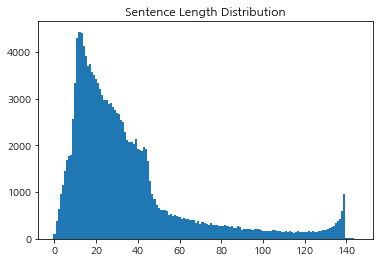

In [12]:
min_len = 999
max_len = 0
sum_len = 0

cleaned_corpus = list(set(raw_train))  # set를 사용해서 중복을 제거합니다.
print("Data Size:", len(cleaned_corpus))

for sen in cleaned_corpus:
    length = len(str(sen))
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(cleaned_corpus))

sentence_length = np.zeros((max_len), dtype=np.int)

for sen in cleaned_corpus:   # 중복이 제거된 코퍼스 기준
    sentence_length[len(str(sen))-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

## 60 이상의 데이터를 제거& 0미만인 데이터도 제거  

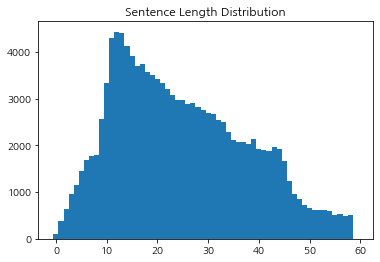

In [13]:
max_len = 60
min_len = 0

# 길이 조건에 맞는 문장만 선택합니다.
filtered_corpus = [s for s in cleaned_corpus if (len(str(s)) < max_len) & (len(str(s)) >= min_len)]

# 분포도를 다시 그려봅니다.
sentence_length = np.zeros((max_len), dtype=np.int)

for sen in filtered_corpus:
    sentence_length[len(str(sen))-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

# 공백 기반 토큰화
정제된 데이터를 공백 기반으로 토큰화하여 list에 저장한 후, 아래 tokenize() 함수를 사용해 단어 사전과 Tensor 데이터를 리턴 

In [14]:
def tokenize(corpus):  # corpus: Tokenized Sentence's List
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    tokenizer.fit_on_texts(corpus)

    tensor = tokenizer.texts_to_sequences(corpus)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, tokenizer

In [15]:
# 정제된 데이터를 공백 기반으로 토큰화하여 저장하는 코드를 직접 작성해 보세요.
split_corpus = []

for kor in filtered_corpus:
    
    # 코드를 작성하세요
    split_corpus.append(str(kor).split())

## 단어 사전의 길이를 확인
- 공백 기반 토큰화로 만들어진 단어 사진 확인

In [16]:
split_tensor, split_tokenizer = tokenize(split_corpus)

print("Split Vocab Size:", len(split_tokenizer.index_word))

Split Vocab Size: 237771


##  단어 사전의 단어 출력

In [17]:
for idx, word in enumerate(split_tokenizer.word_index):
    print(idx, ":", word)

    if idx > 10: break

0 : 영화
1 : 너무
2 : 정말
3 : 진짜
4 : 이
5 : 영화.
6 : 왜
7 : 이런
8 : 그냥
9 : 더
10 : 최고의
11 : 수


# 형태소 기반 토큰화

 KoNLPy, 그중에서도 가장 성능이 준수한 MeCab클래스를 활용해 실습하겠다.

앞서 작성했던 코드를 활용해 MeCab 기반으로 생성된 단어 사전과 Tensor 데이터를 얻어 보자!

In [18]:
from konlpy.tag import Mecab

mecab = Mecab()
print(mecab.morphs('자연어처리가너무재밌어서밥먹는것도가끔까먹어요'))

['자연어', '처리', '가', '너무', '재밌', '어서', '밥', '먹', '는', '것', '도', '가끔', '까먹', '어요']


In [19]:
from konlpy.tag import Hannanum,Kkma,Komoran,Mecab,Okt

mecab = Mecab()


# 위에서 사용한 코드를 활용해 MeCab 단어 사전을 만들어보세요. 
# Hint : mecab.morphs()를 사용해서 형태소분석을 합니다.
def mecab_split(sentence):
    return mecab.morphs(sentence)

mecab_corpus = []
# filtered_corpussms는
# 60 이상의 데이터를 제거& 0 미만인 데이터도 제거된 말뭉치 데이터
for kor in filtered_corpus:
    mecab_corpus.append(mecab_split(str(kor)))

In [20]:
mecab_tensor, mecab_tokenizer = tokenize(mecab_corpus)

print("MeCab Vocab Size:", len(mecab_tokenizer.index_word))

MeCab Vocab Size: 42461


# 1.네이버 영화리뷰 감정분석 코퍼스에 sentencepiece를 적용시킨 모델 학습하기

- SentencePiece 라이브러 설치
```
pip install sentencepiece
```


sentencepiece 모델에 네이버감정분석 코퍼스중 [60 이상의 데이터를 제거& 0미만인 데이터도 제거]의 작업이 수행된 코퍼스로 학습된다.     
filtered_corpus =  60 이상의 데이터를 제거& 0미만인 데이터도 제거


## 1.1. SentencePiece모델01 생성
- 모델 타입 unigram
- 단어 집합 개수 8000개

In [21]:
import sentencepiece as spm
import os
temp_file = os.getenv('HOME')+'/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp'

vocab_size = 8000

with open(temp_file, 'w') as f:
    for row in filtered_corpus:   # 이전 스텝에서 정제했던 corpus를 활용합니다.
        f.write(str(row) + '\n')

spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=naver_korean_spm01  --vocab_size={}'.format(temp_file, vocab_size)    
)
#위 Train에서  --model_type = 'unigram'이 디폴트 적용되어 있습니다. --model_type = 'bpe' 로 옵션을 주어 변경할 수 있습니다.

In [24]:
!ls -l naver_korean_spm01*

-rw-r--r-- 1 aiffel-dj60 aiffel-dj60 375122  4월 16 22:45 naver_korean_spm01.model
-rw-r--r-- 1 aiffel-dj60 aiffel-dj60 144561  4월 16 22:45 naver_korean_spm01.vocab


## 1.2. SentencePiece모델02 생성
- 모델 타입 bpe
- 단어 집합 개수 8000개

In [22]:
import sentencepiece as spm
import os
temp_file = os.getenv('HOME')+'/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp'

vocab_size = 8000

with open(temp_file, 'w') as f:
    for row in filtered_corpus:   # 이전 스텝에서 정제했던 corpus를 활용합니다.
        f.write(str(row) + '\n')

spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=naver_korean_spm02 --model_type=bpe --vocab_size={}'.format(temp_file, vocab_size)    
)
#위 Train에서  --model_type = 'unigram'이 디폴트 적용되어 있습니다. --model_type = 'bpe' 로 옵션을 주어 변경할 수 있습니다.

In [23]:
!ls -l naver_korean_spm02*

-rw-r--r-- 1 aiffel-dj60 aiffel-dj60 370498  4월 16 22:45 naver_korean_spm02.model
-rw-r--r-- 1 aiffel-dj60 aiffel-dj60 115708  4월 16 22:45 naver_korean_spm02.vocab


위 코드를 실행하면 정상적으로 SentencePiece 모델 학습이 완료된 후 koreanspm.model 파일과 koreanspm.vocab vocabulary 파일이 생성되었음을 확인할 수 있습니다.

그럼 이렇게 학습된 SentencePiece 모델을 어떻게 활용

## 1.3. 학습된 모델 불러오기01
- 모델 타입 unigram
- 단어 집합 개수 8000개

In [25]:
s01 = spm.SentencePieceProcessor()
s01.Load('naver_korean_spm01.model')

# SentencePiece를 활용한 sentence -> encoding
tokensIDs = s01.EncodeAsIds('아버지가방에들어가신다.')
print(tokensIDs)

# SentencePiece를 활용한 sentence -> encoded pieces
print(s01.SampleEncodeAsPieces('아버지가방에들어가신다.',1, 0.0))

# SentencePiece를 활용한 encoding -> sentence 복원
print(s01.DecodeIds(tokensIDs))

[1706, 10, 417, 15, 1493, 10, 155, 16, 4]
['▁아버지', '가', '방', '에', '들어', '가', '신', '다', '.']
아버지가방에들어가신다.


## 1.4. 학습된 모델 불러오기02
- 모델 타입 bpe
- 단어 집합 개수 8000개

In [26]:
s02 = spm.SentencePieceProcessor()
s02.Load('naver_korean_spm02.model')

# SentencePiece를 활용한 sentence -> encoding
tokensIDs = s02.EncodeAsIds('아버지가방에들어가신다.')
print(tokensIDs)

# SentencePiece를 활용한 sentence -> encoded pieces
print(s02.SampleEncodeAsPieces('아버지가방에들어가신다.',1, 0.0))

# SentencePiece를 활용한 encoding -> sentence 복원
print(s02.DecodeIds(tokensIDs))

[8, 6435, 984, 6535, 6257, 1519, 6252, 6363, 6246, 6244]
['▁아', '버', '지가', '방', '에', '들어', '가', '신', '다', '.']
아버지가방에들어가신다.


# 2.학습된 모델로 sp_tokenize() 메소드 구현하기

## 2.1. Tokenizer 함수 작성 (SentencePiece를 활용)

- 우리는 위에서 훈련시킨 SentencePiece를 활용하여 위 함수와 유사한 기능을 하는 sp_tokenize() 함수를 정의
- SentencePiece가 동작하는 방식이 단순 토큰화와는 달라 완전히 동일하게는 정의하기 어렵습니다. 

최소한  아래 조건을 만족하는 함수를 정의 할것이다.

1) 매개변수로 토큰화된 문장의 list를 전달하는 대신 온전한 문장의 list 를 전달한다.

2) 생성된 vocab 파일을 읽어와 { : } 형태를 가지는 word_index 사전과 { : } 형태를 가지는 index_word 사전을 생성하고 함께 반환한다.

3) 리턴값인 tensor 는 앞의 함수와 동일하게 토큰화한 후 Encoding된 문장입니다. 바로 학습에 사용할 수 있게 Padding 처리

## 2.2  Tokenizer함수01
- 모델 타입 unigram
- 단어 집합 개수 8000개

In [27]:

def sp_tokenize01(s, corpus):

    tensor = []

    for sen in corpus:
        tensor.append(s.EncodeAsIds(sen))

    with open("./naver_korean_spm01.vocab", 'r') as f:
        vocab = f.readlines()

    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({word:idx})
        index_word.update({idx:word})
    # 패딩을 하였다.
    
    #tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='pre')
    
    return tensor, word_index, index_word

## 2.3  Tokenizer함수02
- 모델 타입 bpe
- 단어 집합 개수 8000개

In [28]:
def sp_tokenize02(s, corpus):

    tensor = []

    for sen in corpus:
        tensor.append(s.EncodeAsIds(sen))
   
    with open("./naver_korean_spm02.vocab", 'r') as f:
        vocab = f.readlines()
    
    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({word:idx})
        index_word.update({idx:word})
    # 패딩을 하였다.
    
    #tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='pre')
    
    return tensor, word_index, index_word

## 2.4. Tokenizer 예시 (모델 타입 unigram) 

In [29]:
#sp_tokenize(s, corpus) 사용예제

my_corpus = ['나는 밥을 먹었습니다.', '그러나 여전히 ㅠㅠ 배가 고픕니다...']
tensor, word_index, index_word = sp_tokenize01(s01, my_corpus)
print(tensor)

[[   0    0    0    0  509 3009   14 1264 1742    4]
 [1499 2117  248  516   10    3   17 7920  821    8]]


## 2.5. Tokenizer 예시 (모델 타입 bpe) 

In [30]:
 #sp_tokenize(s, corpus) 사용예제
my_corpus = ['나는 밥을 먹었습니다.', '그러나 여전히 ㅠㅠ 배가 고픕니다...']
tensor, word_index, index_word = sp_tokenize02(s02, my_corpus)
print(tensor)

[[   0    0    0  673 2890 6274  557  833 6244]
 [1638 2188  312  339 6252  169 7633   15    7]]


# 3. 구현된 토크나이저를 적용하여 네이버 영화리뷰 감정분석 모델을 재학습하기

## 데이터로더 구성(SentencePiece토큰화를 활용한다.) 

load_data(train_data, test_data,stpiece_mmodel)의 3번째 인자에 따른 sentences의 모델이 0 = unigram, 1 = bpe로 구성됩니다. 

In [33]:
#stpiece_model == 0 이면 unigram
#stpiece_model == 0 이면 bpe
def load_data(train_data, test_data, stpiece_model):
    sentences =[]
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 

    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 

    #train데이터 토큰화
    sentences = train_data['document']
   
    
    ## sentencePiece모델 선택 unigram, bpe
    if(stpiece_model == 0): #  0이면 unigram
        tensor, word_index, index_word=sp_tokenize01(s01,sentences)
    elif(stpiece_model == 1): # 1이면 bpe
        tensor, word_index, index_word=sp_tokenize02(s02,sentences)
    
    #train문장데이터를 수치화로 표현화한 리스트
    X_train = []
    ## 수치화된 문장(텐서)를 리스트(sentences_index)에 넣어준다. 
    for array in tensor:
        #X_train.append(array.tolist())
        X_train.append(array)
   
   

    #test데이터 토큰화
    sentences = test_data['document']
   
    if(stpiece_model == 0): #  0이면 unigram
        tensor, word_index, index_word=sp_tokenize01(s01,sentences)
    elif(stpiece_model == 1): # 1이면 bpe
        tensor, word_index, index_word=sp_tokenize02(s02,sentences)
    
    
    #test문장데이터를 수치화로 표현화한 리스트
    X_test = []
    ## 수치화된 문장(텐서)를 리스트(sentences_index)에 넣어준다. 
    for array in tensor:
        #print(array.tolist())
        #X_test.append(array.tolist())
        X_test.append(array)
          
    X_train = np.asarray(X_train)
    X_test = np.asarray(X_test)
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_index


In [34]:
#unigram
X_train01, y_train01, X_test01, y_test01, word_to_index01 =load_data(train_data, test_data,0)

In [35]:
# bpe
X_train02, y_train02, X_test02, y_test02, word_to_index02 =load_data(train_data, test_data,1)

In [37]:
X_train01.shape

(146182, 133)

In [38]:
X_train02.shape

(146182, 131)

### sp_tokenize함수에서 padding을 post로 했을때

X_train.shape => (146182, 140)

### sp_tokenize함수에서 padding을 pre로 했을때
X_train.shape =. (125132, 50)

## 데이터 셋 분리

In [39]:
# validation set 10000건 분리
X_val01 = X_train01[:10000]   
y_val01 = y_train01[:10000]

# validation set을 제외한 나머지 15000건
partial_X_train01 = X_train01[10000:]  
partial_y_train01 = y_train01[10000:]

print(X_train01.shape)
print(y_train01.shape)
print(partial_X_train01.shape)
print(partial_y_train01.shape)

(146182, 133)
(146182,)
(136182, 133)
(136182,)


In [53]:
# validation set 10000건 분리
X_val02 = X_train02[:10000]   
y_val02 = y_train02[:10000]

# validation set을 제외한 나머지 15000건
partial_X_train02 = X_train02[10000:]  
partial_y_train02 = y_train02[10000:]

print(X_train02.shape)
print(y_train02.shape)
print(partial_X_train02.shape)
print(partial_y_train02.shape)

(146182, 131)
(146182,)
(136182, 131)
(136182,)


## LSTM모델

In [44]:
vocab_size = 8000    # 어휘 사전의 크기입니다(8,000개의 단어)
word_vector_dim = 133  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)


#LSTM
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.LSTM(word_vector_dim))   # 가장 널리 쓰이는 RNN인 LSTM 레이어
model.add(keras.layers.Dense(10, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid')) 
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 133)         1064000   
_________________________________________________________________
lstm (LSTM)                  (None, 133)               142044    
_________________________________________________________________
dense (Dense)                (None, 10)                1340      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 1,207,395
Trainable params: 1,207,395
Non-trainable params: 0
_________________________________________________________________


In [56]:
vocab_size = 8000    # 어휘 사전의 크기입니다(8,000개의 단어)
word_vector_dim = 131  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)


#LSTM
model02 = keras.Sequential()
model02.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model02.add(keras.layers.LSTM(word_vector_dim))   # 가장 널리 쓰이는 RNN인 LSTM 레이어
model02.add(keras.layers.Dense(10, activation='relu'))
model02.add(keras.layers.Dense(1, activation='sigmoid')) 
model02.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 131)         1048000   
_________________________________________________________________
lstm_2 (LSTM)                (None, 131)               137812    
_________________________________________________________________
dense_4 (Dense)              (None, 10)                1320      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 11        
Total params: 1,187,143
Trainable params: 1,187,143
Non-trainable params: 0
_________________________________________________________________


### sentences(unigram) 인 경우 

In [51]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history_model01 = model.fit(partial_X_train01,partial_y_train01,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val01, y_val01),
                    verbose=2)

results = model.evaluate(X_test01,  y_test01, verbose=2)
print(results)

Epoch 1/10
266/266 - 16s - loss: 0.4209 - accuracy: 0.8039 - val_loss: 0.3323 - val_accuracy: 0.8578
Epoch 2/10
266/266 - 13s - loss: 0.3181 - accuracy: 0.8633 - val_loss: 0.3270 - val_accuracy: 0.8574
Epoch 3/10
266/266 - 13s - loss: 0.2898 - accuracy: 0.8758 - val_loss: 0.3134 - val_accuracy: 0.8652
Epoch 4/10
266/266 - 14s - loss: 0.2635 - accuracy: 0.8877 - val_loss: 0.3361 - val_accuracy: 0.8629
Epoch 5/10
266/266 - 13s - loss: 0.2402 - accuracy: 0.8977 - val_loss: 0.3338 - val_accuracy: 0.8589
Epoch 6/10
266/266 - 13s - loss: 0.2189 - accuracy: 0.9070 - val_loss: 0.3431 - val_accuracy: 0.8569
Epoch 7/10
266/266 - 13s - loss: 0.1983 - accuracy: 0.9164 - val_loss: 0.3689 - val_accuracy: 0.8552
Epoch 8/10
266/266 - 13s - loss: 0.1767 - accuracy: 0.9270 - val_loss: 0.4120 - val_accuracy: 0.8510
Epoch 9/10
266/266 - 13s - loss: 0.1553 - accuracy: 0.9361 - val_loss: 0.4403 - val_accuracy: 0.8480
Epoch 10/10
266/266 - 13s - loss: 0.1367 - accuracy: 0.9441 - val_loss: 0.4775 - val_accura

### sentences(bpe) 인 경우 

In [57]:
model02.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history_model02 = model02.fit(partial_X_train02,partial_y_train02,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val02, y_val02),
                    verbose=2)

results = model02.evaluate(X_test02,  y_test02, verbose=2)
print(results)

Epoch 1/10
266/266 - 15s - loss: 0.4274 - accuracy: 0.8018 - val_loss: 0.3450 - val_accuracy: 0.8482
Epoch 2/10
266/266 - 13s - loss: 0.3235 - accuracy: 0.8619 - val_loss: 0.3300 - val_accuracy: 0.8561
Epoch 3/10
266/266 - 13s - loss: 0.2996 - accuracy: 0.8725 - val_loss: 0.3209 - val_accuracy: 0.8606
Epoch 4/10
266/266 - 13s - loss: 0.2717 - accuracy: 0.8845 - val_loss: 0.3245 - val_accuracy: 0.8603
Epoch 5/10
266/266 - 13s - loss: 0.2453 - accuracy: 0.8959 - val_loss: 0.3342 - val_accuracy: 0.8583
Epoch 6/10
266/266 - 13s - loss: 0.2231 - accuracy: 0.9060 - val_loss: 0.3588 - val_accuracy: 0.8575
Epoch 7/10
266/266 - 13s - loss: 0.2029 - accuracy: 0.9143 - val_loss: 0.3665 - val_accuracy: 0.8566
Epoch 8/10
266/266 - 13s - loss: 0.1837 - accuracy: 0.9219 - val_loss: 0.3909 - val_accuracy: 0.8529
Epoch 9/10
266/266 - 13s - loss: 0.1612 - accuracy: 0.9319 - val_loss: 0.4508 - val_accuracy: 0.8499
Epoch 10/10
266/266 - 14s - loss: 0.1407 - accuracy: 0.9407 - val_loss: 0.4999 - val_accura

# 4.KoNLPy 형태소 분석기를 사용한 모델과 성능 비교하기

In [8]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter
# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/ratings_test.txt')

## Mecab 객체 생성

In [9]:
from konlpy.tag import Hannanum,Kkma,Komoran,Mecab,Okt

tokenizer = Mecab()

## 전처리 작업

In [40]:
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']
# 데이터의 중복 제거   
# NaN 결측치 제거   
# 한국어 토크나이저로 토큰화   
# 불용어(Stopwords) 제거   
# 사전word_to_index 구성   
# 텍스트 스트링을 사전 인덱스 스트링으로 변환   
# X_train, y_train, X_test, y_test, word_to_index 리턴  

def load_data_macab(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 

    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)

    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}

    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
    
    X_train = list(map(wordlist_to_indexlist, X_train))
    #print(X_train[0])
    X_test = list(map(wordlist_to_indexlist, X_test))
    ## X_train, y_train, X_test, y_test, word_to_index 리턴    
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

X_train03, y_train03, X_test03, y_test03, word_to_index03 = load_data_macab(train_data, test_data)

In [41]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

## 문장 최대 길이 maxlen의 값 찾기

In [42]:
total_data_text = list(X_train03) + list(X_test03)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.96938143432699
문장길이 최대 :  116
문장길이 표준편차 :  12.843571939469296
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


### 패딩 적용

In [43]:
#RNN은 입력데이터가 순차적으로 처리되기 때문에 뒤부분 입력이 패딩값(padding)으로 채워지면 비효율적이다.
X_train03 = keras.preprocessing.sequence.pad_sequences(X_train03,
                                                     value=word_to_index03["<PAD>"],
                                                     padding='pre',# 혹은'post'
                                                     maxlen=maxlen)

X_test03 = keras.preprocessing.sequence.pad_sequences(X_test03,
                                                    value=word_to_index03["<PAD>"],
                                                    padding='pre', # 혹은 'post'
                                                    maxlen=maxlen)
print(X_train03.shape)

(146182, 41)


In [44]:
# validation set 10000건 분리
X_val03 = X_train03[:10000]   
y_val03 = y_train03[:10000]

# validation set을 제외한 나머지 15000건
partial_X_train03 = X_train03[10000:]  
partial_y_train03 = y_train03[10000:]

print(X_train03.shape)
print(y_train03.shape)
print(partial_X_train03.shape)
print(partial_y_train03.shape)

(146182, 41)
(146182,)
(136182, 41)
(136182,)


In [49]:

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 41  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

# model 설계
model03 = keras.Sequential()
model03.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model03.add(keras.layers.LSTM(word_vector_dim))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경가능)
model03.add(keras.layers.Dense(32, activation='relu'))
model03.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model03.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, None, 41)          410000    
_________________________________________________________________
lstm_14 (LSTM)               (None, 41)                13612     
_________________________________________________________________
dense_28 (Dense)             (None, 32)                1344      
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 33        
Total params: 424,989
Trainable params: 424,989
Non-trainable params: 0
_________________________________________________________________


In [50]:
model03.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history_model03 = model03.fit(partial_X_train03,partial_y_train03,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val03, y_val03),
                    verbose=2)

results = model03.evaluate(X_test03,  y_test03, verbose=2)
print(results)

Epoch 1/10
266/266 - 3s - loss: 0.4270 - accuracy: 0.8039 - val_loss: 0.3460 - val_accuracy: 0.8495
Epoch 2/10
266/266 - 2s - loss: 0.3309 - accuracy: 0.8588 - val_loss: 0.3349 - val_accuracy: 0.8538
Epoch 3/10
266/266 - 2s - loss: 0.3120 - accuracy: 0.8673 - val_loss: 0.3360 - val_accuracy: 0.8524
Epoch 4/10
266/266 - 2s - loss: 0.2960 - accuracy: 0.8738 - val_loss: 0.3344 - val_accuracy: 0.8571
Epoch 5/10
266/266 - 2s - loss: 0.2777 - accuracy: 0.8818 - val_loss: 0.3414 - val_accuracy: 0.8597
Epoch 6/10
266/266 - 2s - loss: 0.2589 - accuracy: 0.8899 - val_loss: 0.3546 - val_accuracy: 0.8506
Epoch 7/10
266/266 - 2s - loss: 0.2406 - accuracy: 0.8985 - val_loss: 0.3468 - val_accuracy: 0.8563
Epoch 8/10
266/266 - 2s - loss: 0.2247 - accuracy: 0.9061 - val_loss: 0.3823 - val_accuracy: 0.8506
Epoch 9/10
266/266 - 2s - loss: 0.2092 - accuracy: 0.9130 - val_loss: 0.3862 - val_accuracy: 0.8486
Epoch 10/10
266/266 - 2s - loss: 0.1963 - accuracy: 0.9192 - val_loss: 0.4040 - val_accuracy: 0.8508

## 성능비교 
```
Sentence(Unigram) 단어집합크기 8천    :loss: 0.4801 - accuracy: 0.8464
Sentence(BPE)     단어집합크기 8천    :loss: 0.5081 - accuracy: 0.8457
Macab             단어집합크기 8천    :loss: 0.4151 - accuracy: 0.8468

성능 비교로 확인 했을 때 3가지는 큰 차이가 없다.
        
```
     

#### 평가문항
#### 상세기준

#### 1. SentencePiece를 이용하여 모델을 만들기까지의 과정이 정상적으로 진행되었는가?
    -코퍼스 분석, 전처리, SentencePiece 적용, 토크나이저 구현 및 동작이 빠짐없이 진행되었는가?
#### 2. SentencePiece를 통해 만든 Tokenizer가 자연어처리 모델과 결합하여 동작하는가?
    -SentencePiece 토크나이저가 적용된 Text Classifier 모델이 정상적으로 수렴하여 80% 이상의 test accuracy가 확인되었다.
#### 3. SentencePiece의 성능을 다각도로 비교분석하였는가?
    -SentencePiece 토크나이저를 활용했을 때의 성능을 다른 토크나이저 혹은 SentencePiece의 다른 옵션의 경우와 비교하여 분석을 체계적으로 진행하였다.

#### 프로젝트를 하면서 아쉬운점
모델별, 단어집합크기별 확인하고 싶었으나 하지 못했다. 코드를 조금더 효율적으로 짜면 길지 않으면서도 함수의 인자에 값만 던져주어 만들수 있을것 같지만 시간부족상 하지는 못했다.

## Going Deeper(NLP)_1장 2장 요약

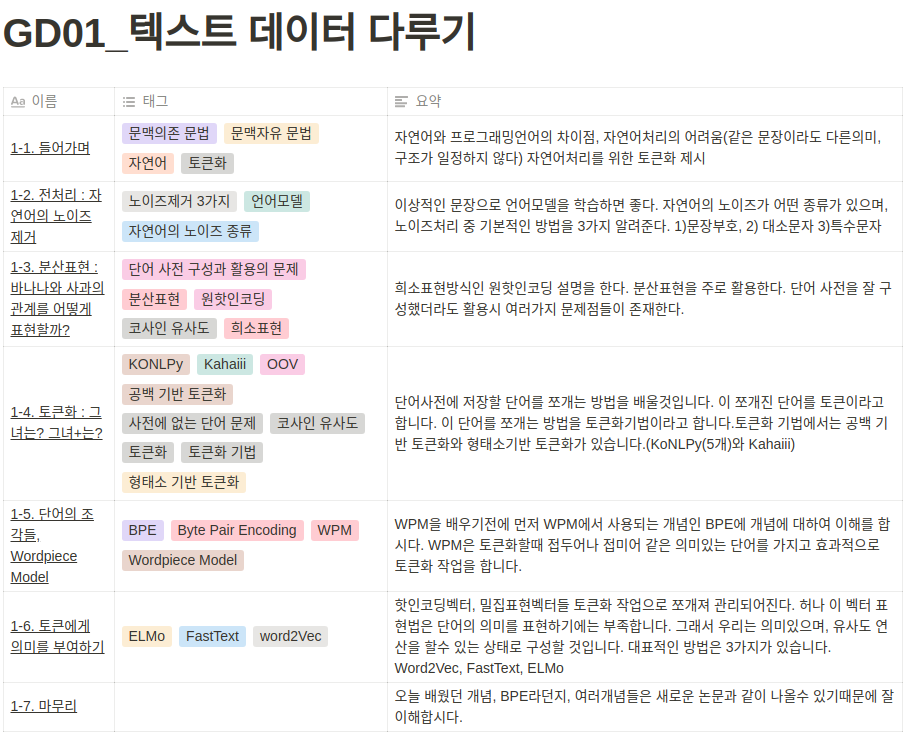

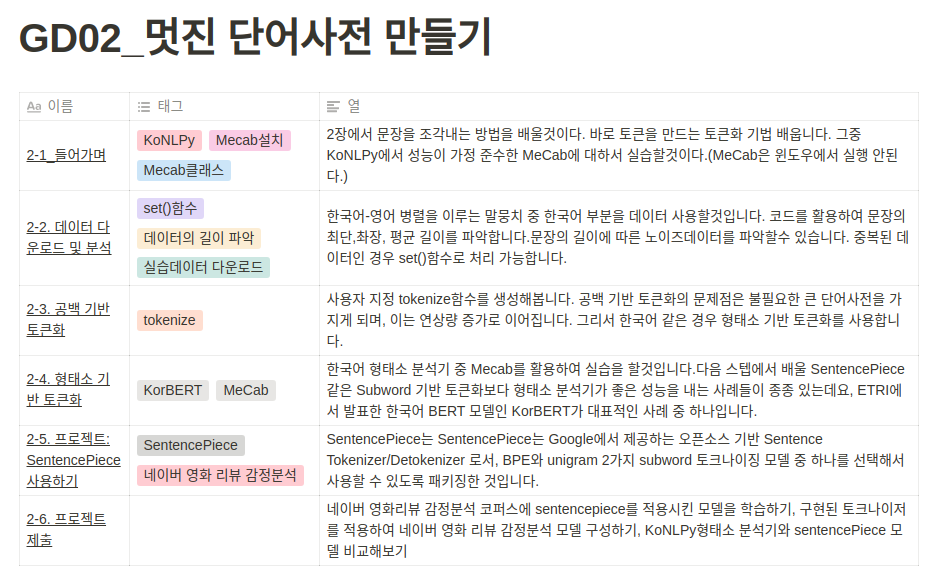

참조 사이트 :

[구글: SentencePiece 사용법 Google: SentencePiece Tutorial](https://choice-life.tistory.com/12)

[위키독스:센텐스피스](https://wikidocs.net/86657)